[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\vikto\AppData\Local\Temp\ipykernel_20720\2777446469.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.02308587230709962' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  aligned_returns.at[aligned_returns.index[i], 'Target Fund'] = new_value


NaN values in SP500:
0
NaN values in UST10Y:
0
NaN values in SP500 pct change:
1
NaN values in UST10Y pct change:
1


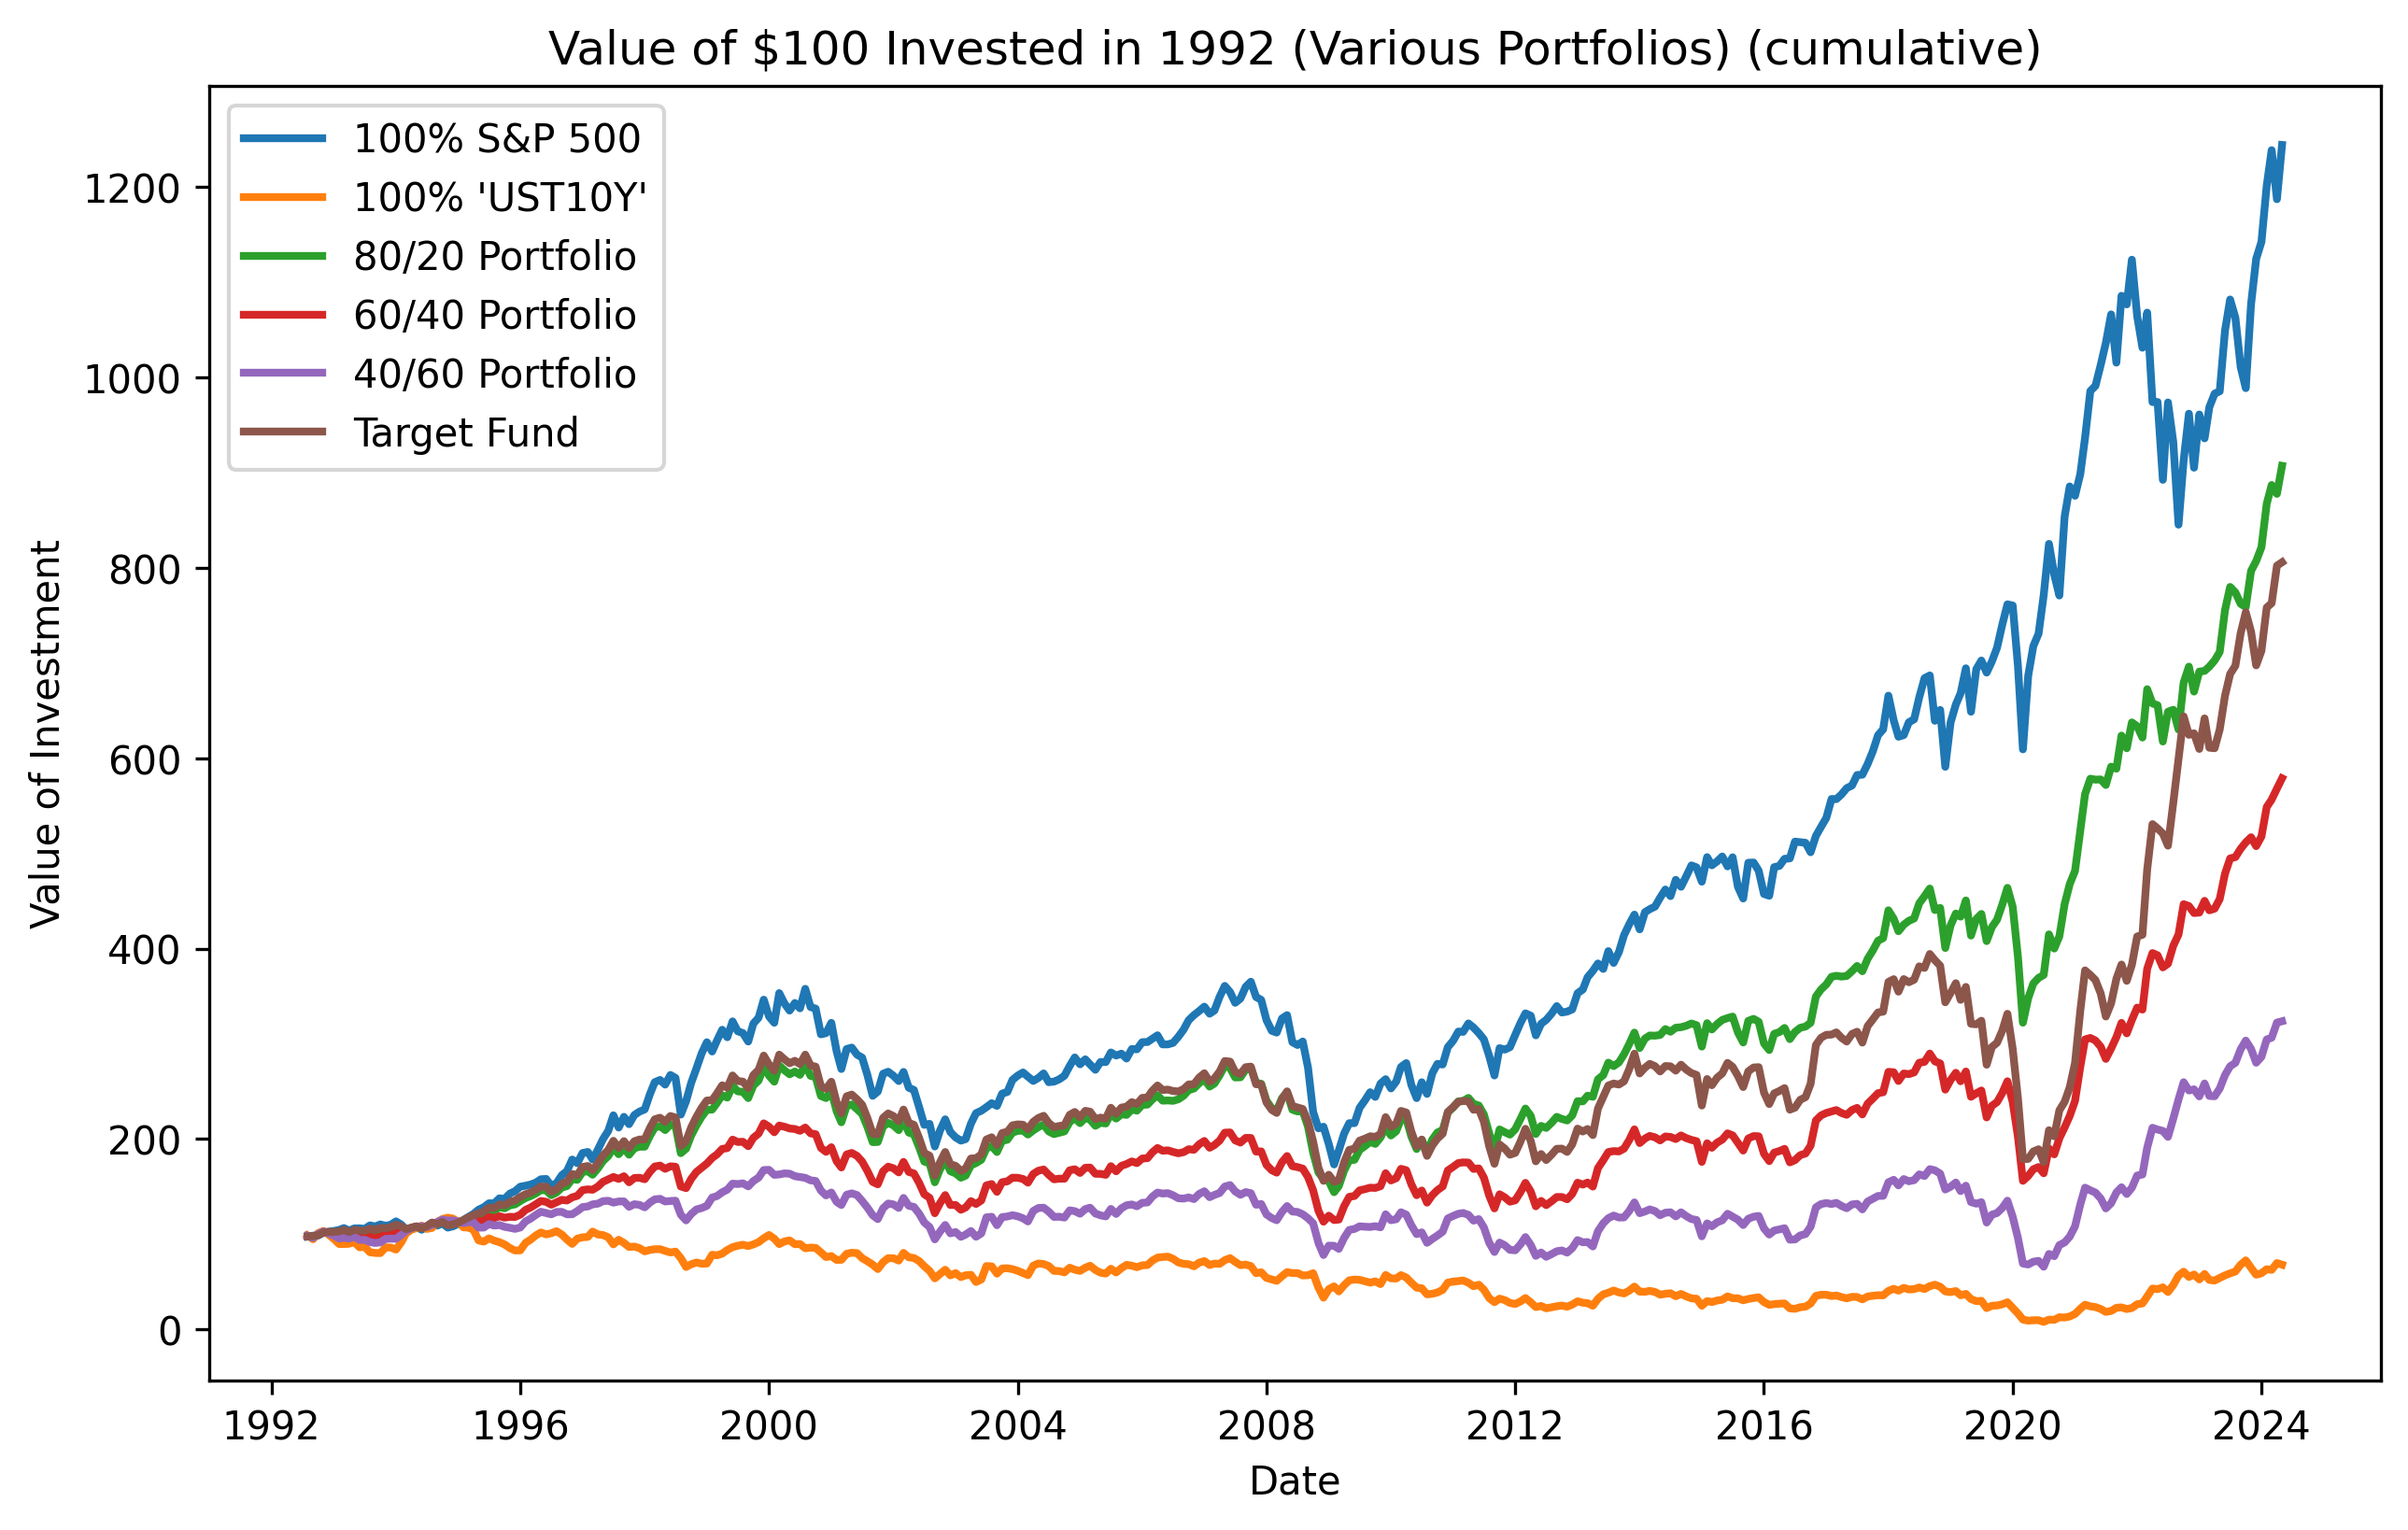

,SP500,UST10Y,80/20 Portfolio,60/40 Portfolio,40/60 Portfolio,Target Fund
Date,,,,,,
1992-08-01,-0.023998,-0.014881,-0.022174,-0.020351,-0.018528,-0.023086
1992-09-01,0.009106,-0.037764,-0.000268,-0.009642,-0.019016,0.004357
1992-10-01,0.002106,0.067504,0.015186,0.028265,0.041345,0.008818
1992-11-01,0.030262,0.022059,0.028621,0.026981,0.025340,0.029409
1992-12-01,0.010108,-0.035971,0.000892,-0.008324,-0.017540,0.005258
...,...,...,...,...,...,...
2024-01-01,0.015896,0.026125,0.017942,0.019988,0.022033,0.021980
2024-02-01,0.051721,0.071843,0.055745,0.059769,0.063794,0.063715
2024-03-01,0.031019,-0.010818,0.022651,0.014284,0.005916,0.006026


In [13]:
import sys
import subprocess
import importlib
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Ensure packages are properly installed and imported
def install_and_import(package, alias=None):
    try:
        module = importlib.import_module(package)
    except ImportError:
        print(f"{package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} installed successfully.")
        module = importlib.import_module(package)
        
    if alias:
        globals()[alias] = module
    else:
        globals()[package] = module

install_and_import('yfinance', alias='yf')
yf = globals()['yf']

# Function to calculate volatility
def vol_s(x):
    x = np.array(x)
    n = len(x)
    x_bar = np.mean(x)
    stdev = np.sqrt(np.sum((x - x_bar)**2) / (n - 1))
    return stdev

# Annualize return
def annualize_return(x):
    return (1 + x)**12 - 1

# Define start and end dates
startdate = "1992-07-01"
startyear = startdate.split("-")[0]
end_date_vfinx = "2024-08-01"
end_date_gspix = "2024-07-01"

# Convert dates to datetime objects
startdate_dt = datetime.datetime.strptime(startdate, "%Y-%m-%d")
end_date_vfinx_dt = datetime.datetime.strptime(end_date_vfinx, "%Y-%m-%d")
end_date_gspix_dt = datetime.datetime.strptime(end_date_gspix, "%Y-%m-%d")

# Download S&P 500 data
SP500 = yf.download("^GSPC", start=startdate_dt, end=end_date_vfinx_dt, interval="1mo")

# Download 10-year U.S. Treasury bond data
UST10Y = yf.download("^TNX", start=startdate_dt, end=end_date_gspix_dt, interval="1mo")

# Remove NA values
print("NaN values in SP500:")
print(SP500['Adj Close'].isna().sum())
print("NaN values in UST10Y:")
print(UST10Y['Adj Close'].isna().sum())

prices_data = pd.concat([SP500['Adj Close'], UST10Y['Adj Close']], axis=1, join='inner')
prices_data.columns = ['SP500', 'UST10Y']

# Calculate percentage returns
print("NaN values in SP500 pct change:")
print(SP500['Adj Close'].pct_change().isna().sum())
print("NaN values in UST10Y pct change:")
print(UST10Y['Adj Close'].pct_change().isna().sum())

SP500_returns = SP500['Adj Close'].pct_change().dropna()
UST10Y_returns = UST10Y['Adj Close'].pct_change().dropna()

# Align both SP500_returns and UST10Y_returns by date
aligned_returns = pd.concat([SP500_returns, UST10Y_returns], axis=1, join='inner')
aligned_returns.columns = ['SP500', 'UST10Y']

aligned_returns['80/20 Portfolio'] = 0.8* aligned_returns['SP500'] + 0.2* aligned_returns['UST10Y']
aligned_returns['60/40 Portfolio'] = 0.6* aligned_returns['SP500'] + 0.4* aligned_returns['UST10Y']
aligned_returns['40/60 Portfolio'] = 0.4* aligned_returns['SP500'] + 0.6* aligned_returns['UST10Y']

# Target date fund allocation: 90% S&P and 10% Bonds to 40% S&P and 60% Bonds over 35 years
weight_date_row = (0.9 - 0.4) / (len(aligned_returns) - 1)
aligned_returns['Target Fund'] = 0

for i in range(len(aligned_returns)):
    new_value = aligned_returns.iloc[i]['SP500'] * (0.9 - weight_date_row * i) + \
                aligned_returns.iloc[i]['UST10Y'] * (0.1 + weight_date_row * i)
    
    aligned_returns.at[aligned_returns.index[i], 'Target Fund'] = new_value
    #print(0.9 - weight_date_row * i) 

# Plot returns
#plt.figure(figsize=(10, 6), dpi=300)
#plt.plot((1 + aligned_returns['SP500']), label="100% S&P 500", linewidth=2)
#plt.plot((1 + aligned_returns['UST10Y']), label="100% 'UST10Y'", linewidth=2)
#plt.plot((1 + aligned_returns['80/20 Portfolio']), label="80/20 Portfolio", linewidth=2)
#plt.plot((1 + aligned_returns['60/40 Portfolio']), label="60/40 Portfolio", linewidth=2)
#plt.plot((1 + aligned_returns['40/60 Portfolio']), label="40/60 Portfolio", linewidth=2)
#plt.plot((1 + aligned_returns['Target Fund']), label="Target Fund", linewidth=2)

#plt.title(f'Value of $100 Invested in {startyear} (Various Portfolios)')
#plt.xlabel("Date")
#plt.ylabel("Value of Investment")
#plt.legend(loc="upper left")
#plt.savefig('./portfolio_returns.jpg')

# Show plot
plt.show()

# Plot cumulative returns
plt.figure(figsize=(10, 6), dpi=300)
plt.plot((1 + aligned_returns['SP500']).cumprod() * 100, label="100% S&P 500", linewidth=2)
plt.plot((1 + aligned_returns['UST10Y']).cumprod() * 100, label="100% 'UST10Y'", linewidth=2)
plt.plot((1 + aligned_returns['80/20 Portfolio']).cumprod() * 100, label="80/20 Portfolio", linewidth=2)
plt.plot((1 + aligned_returns['60/40 Portfolio']).cumprod() * 100, label="60/40 Portfolio", linewidth=2)
plt.plot((1 + aligned_returns['40/60 Portfolio']).cumprod() * 100, label="40/60 Portfolio", linewidth=2)
plt.plot((1 + aligned_returns['Target Fund']).cumprod() * 100, label="Target Fund", linewidth=2)

plt.title(f'Value of $100 Invested in {startyear} (Various Portfolios) (cumulative)')
plt.xlabel("Date")
plt.ylabel("Value of Investment")
plt.legend(loc="upper left")
plt.savefig('./portfolio_cumulative_returns.jpg')
plt.show()

aligned_returns

No N/A's given, meaning that we can proceed.

C:\Users\vikto\AppData\Local\Temp\ipykernel_20720\1339712831.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(prices_data.index, np.log(prices_data['SP500']) - np.log(prices_data['SP500'][0]),
C:\Users\vikto\AppData\Local\Temp\ipykernel_20720\1339712831.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(prices_data.index, np.log(prices_data['UST10Y']) - np.log(prices_data['UST10Y'][0]),


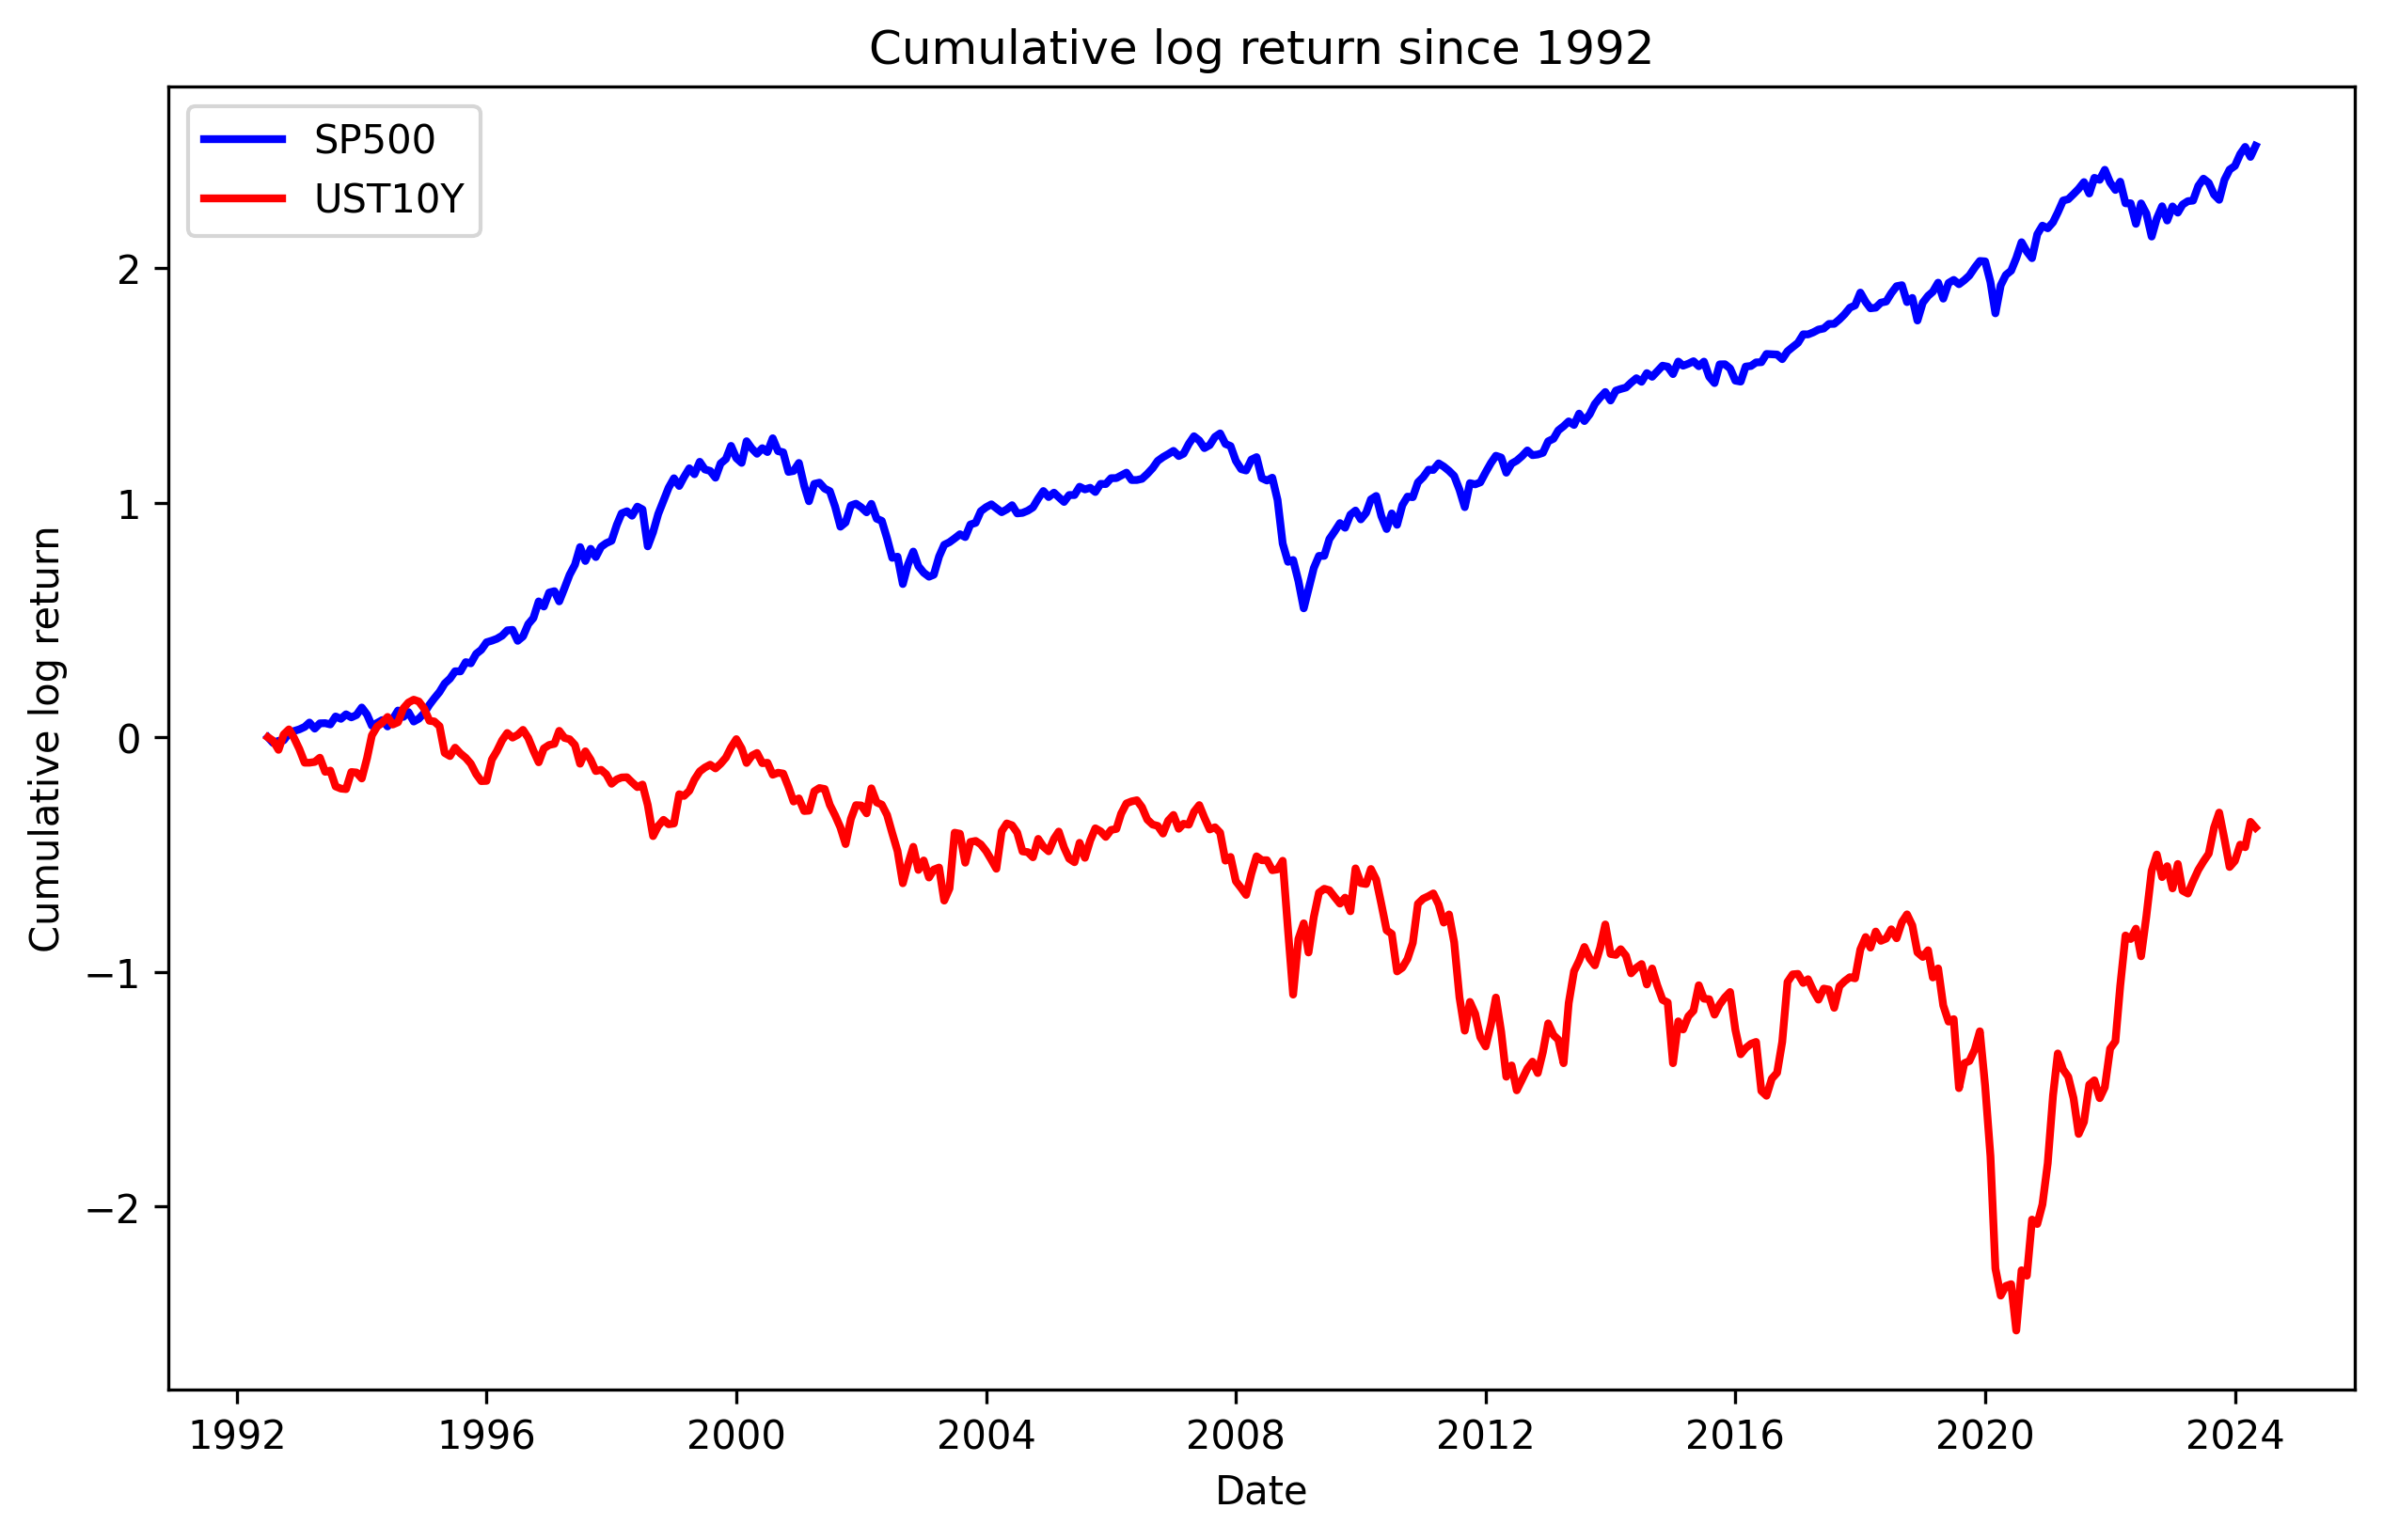

In [14]:
# Step 4. Report - Figure 1b: Cumulative Returns (With Log Scale)

# Plot data
plt.figure(figsize=(10, 6),dpi = 300)


plt.plot(prices_data.index, np.log(prices_data['SP500']) - np.log(prices_data['SP500'][0]), 
         label="SP500", color='blue', linewidth=2)
plt.plot(prices_data.index, np.log(prices_data['UST10Y']) - np.log(prices_data['UST10Y'][0]), 
         label="UST10Y", color='red', linewidth=2)

# Add title and labels
plt.title(f'Cumulative log return since {startyear}')
plt.xlabel("Date")
plt.ylabel("Cumulative log return")

# Add legend
plt.legend(loc="upper left")

# Show plot
plt.show()

c:\Users\vikto\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vikto\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vikto\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vikto\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

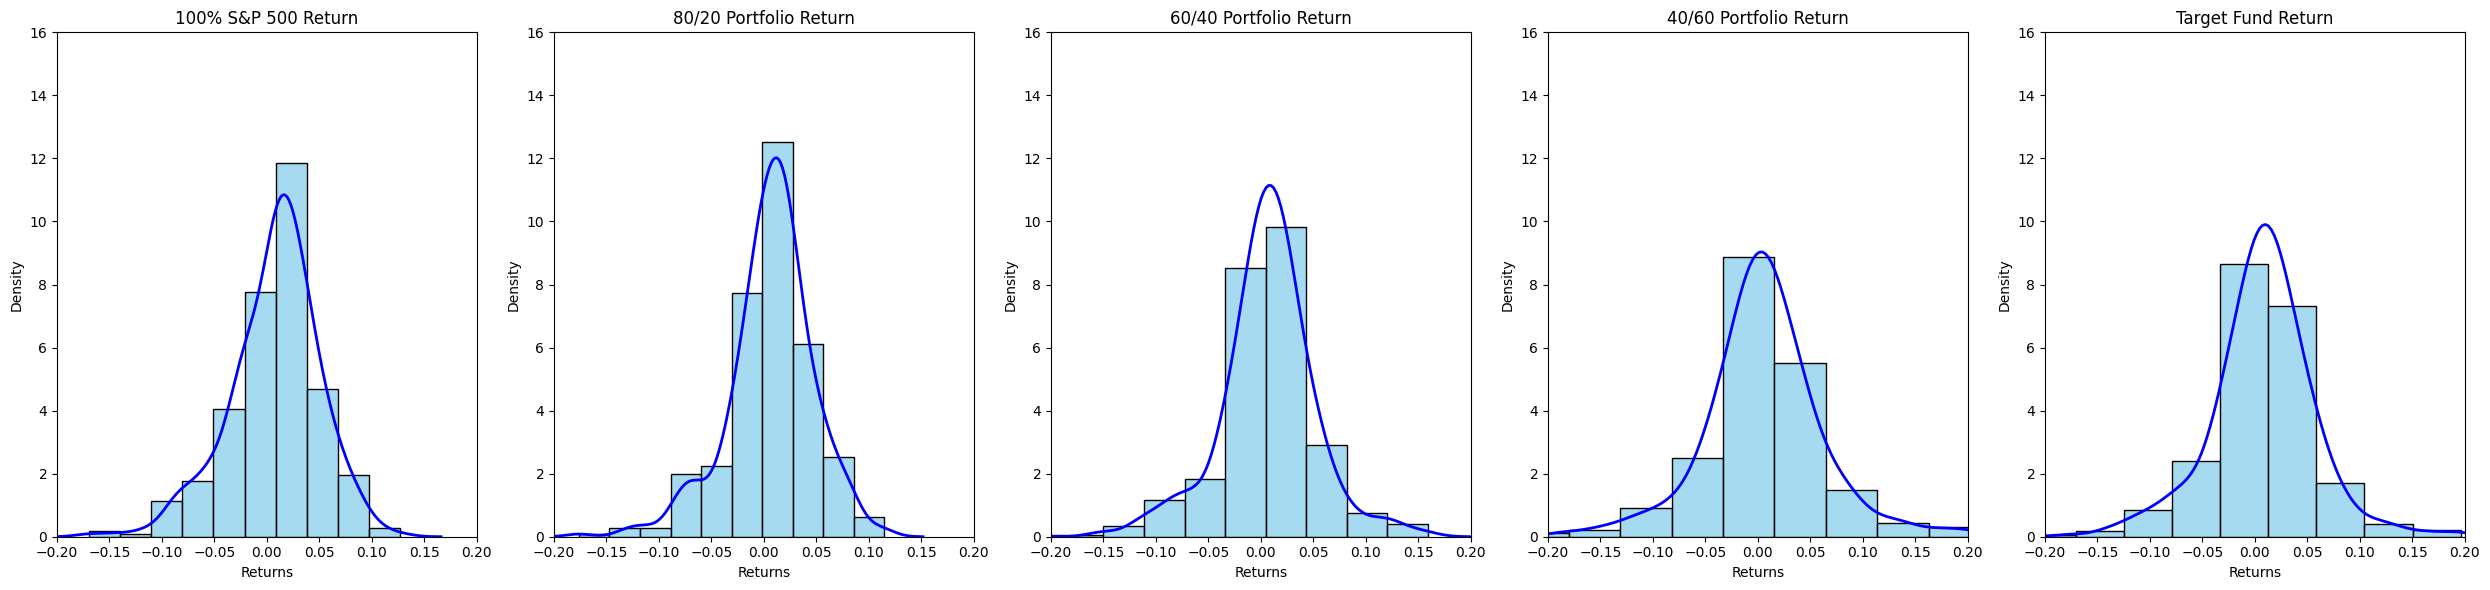

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 5 subplots
fig, ax = plt.subplots(1, 5, figsize=(25, 6))  # Adjusted figsize for better display of 5 plots

# Histogram and Density for 100% S&P 500
sns.histplot(aligned_returns['SP500'], bins=10, kde=False, ax=ax[0], color='skyblue', stat='density')
ax[0].set_xlim(-0.2, 0.2)
ax[0].set_ylim(0, 16)
ax[0].set_xlabel("Returns")
ax[0].set_title("100% S&P 500 Return")
sns.kdeplot(aligned_returns['SP500'], ax=ax[0], color='blue', linewidth=2)

# Histogram and Density for 80/20 Portfolio
sns.histplot(aligned_returns['80/20 Portfolio'], bins=10, kde=False, ax=ax[1], color='skyblue', stat='density')
ax[1].set_xlim(-0.2, 0.2)
ax[1].set_ylim(0, 16)
ax[1].set_xlabel("Returns")
ax[1].set_title("80/20 Portfolio Return")
sns.kdeplot(aligned_returns['80/20 Portfolio'], ax=ax[1], color='blue', linewidth=2)

# Histogram and Density for 60/40 Portfolio
sns.histplot(aligned_returns['60/40 Portfolio'], bins=10, kde=False, ax=ax[2], color='skyblue', stat='density')
ax[2].set_xlim(-0.2, 0.2)
ax[2].set_ylim(0, 16)
ax[2].set_xlabel("Returns")
ax[2].set_title("60/40 Portfolio Return")
sns.kdeplot(aligned_returns['60/40 Portfolio'], ax=ax[2], color='blue', linewidth=2)

# Histogram and Density for 40/60 Portfolio
sns.histplot(aligned_returns['40/60 Portfolio'], bins=10, kde=False, ax=ax[3], color='skyblue', stat='density')
ax[3].set_xlim(-0.2, 0.2)
ax[3].set_ylim(0, 16)
ax[3].set_xlabel("Returns")
ax[3].set_title("40/60 Portfolio Return")
sns.kdeplot(aligned_returns['40/60 Portfolio'], ax=ax[3], color='blue', linewidth=2)

# Histogram and Density for Target Fund
sns.histplot(aligned_returns['Target Fund'], bins=10, kde=False, ax=ax[4], color='skyblue', stat='density')
ax[4].set_xlim(-0.2, 0.2)
ax[4].set_ylim(0, 16)
ax[4].set_xlabel("Returns")
ax[4].set_title("Target Fund Return")
sns.kdeplot(aligned_returns['Target Fund'], ax=ax[4], color='blue', linewidth=2)

# Show the plot
plt.tight_layout()
plt.show()



In [35]:
# Calculate Standard Deviation
std_dev = aligned_returns.std()

# Calculate Skewness
skewness = aligned_returns.skew()

# Calculate Kurtosis
kurtosis = aligned_returns.kurtosis()

print("Standard Deviation of Returns:")
print(std_dev)
print("\nSkewness of Returns:")
print(skewness)
print("\nKurtosis of Returns:")
print(kurtosis)



Standard Deviation of Returns:
SP500              0.042892
UST10Y             0.088537
80/20 Portfolio    0.040564
60/40 Portfolio    0.046348
40/60 Portfolio    0.057862
Target Fund        0.051196
dtype: float64

Skewness of Returns:
SP500             -0.594219
UST10Y             0.264059
80/20 Portfolio   -0.683085
60/40 Portfolio   -0.467166
40/60 Portfolio   -0.129402
Target Fund       -0.375894
dtype: float64

Kurtosis of Returns:
SP500              1.054743
UST10Y             2.650876
80/20 Portfolio    1.749747
60/40 Portfolio    2.796010
40/60 Portfolio    3.003198
Target Fund        3.304644
dtype: float64


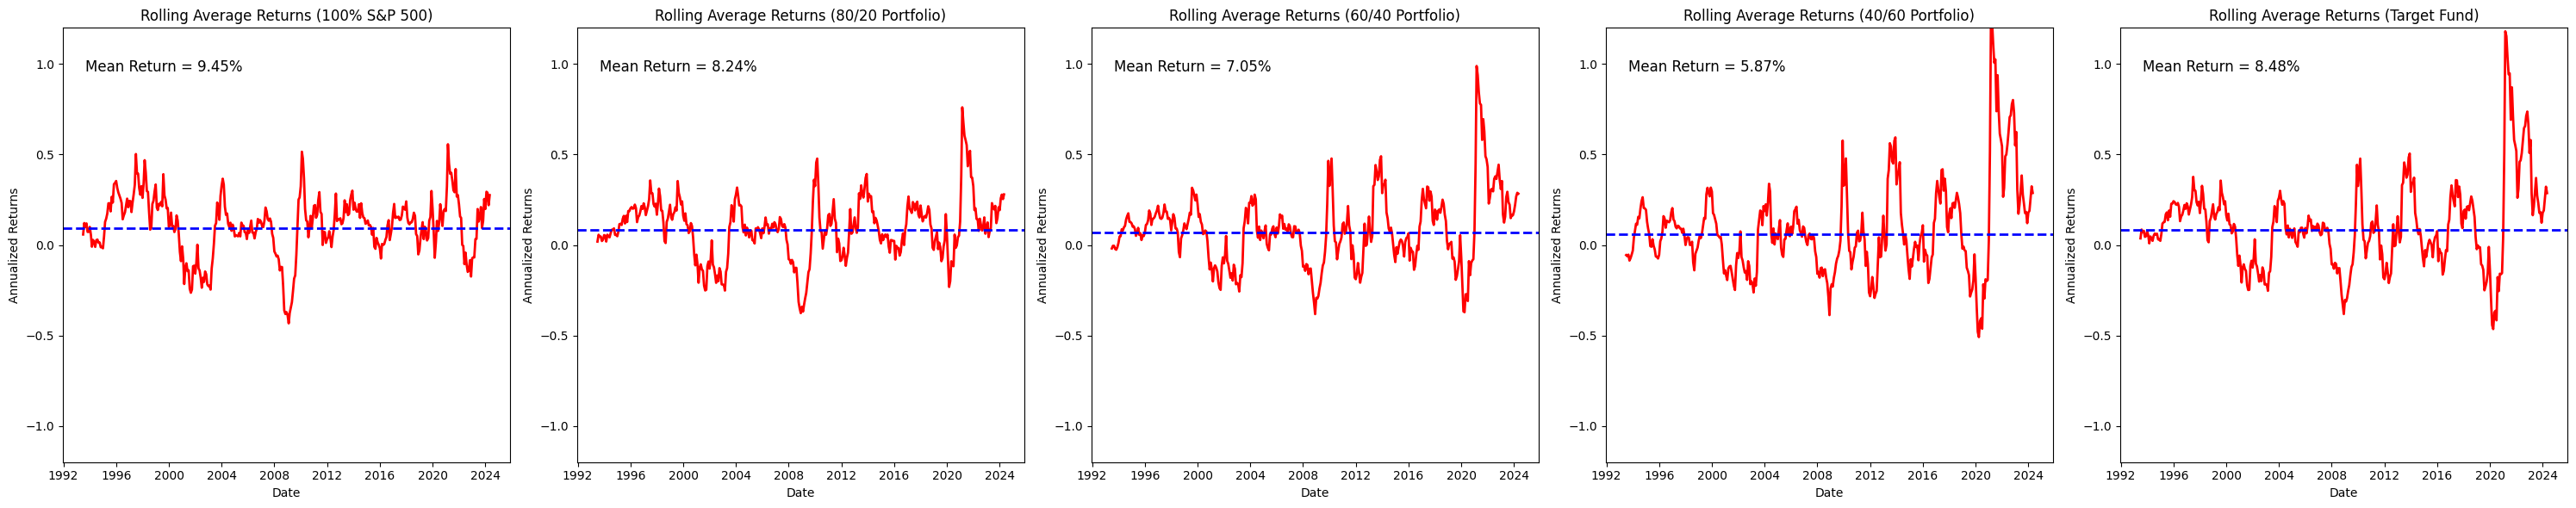

In [30]:
portfolios = {
    'SP500': "100% S&P 500",
    '80/20 Portfolio': "80/20 Portfolio",
    '60/40 Portfolio': "60/40 Portfolio",
    '40/60 Portfolio': "40/60 Portfolio",
    'Target Fund': "Target Fund"
}

# Create a figure with multiple subplots (one for each portfolio)
fig, ax = plt.subplots(1, 5, figsize=(30, 6))

# Loop through the portfolios to plot each
for i, (key, title) in enumerate(portfolios.items()):
    # Plot rolling average returns
    ax[i].plot(annualized_rollmean[key], color='red', linewidth=2)
    ax[i].set_title(f"Rolling Average Returns ({title})")
    ax[i].set_ylim(-1.2, 1.2)
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Annualized Returns")

    # Calculate and plot the mean return as a horizontal line
    annualized_mean = annualize_return(aligned_returns[key].mean()) 
    ax[i].axhline(y=annualized_mean, color='blue', linestyle='--', linewidth=2)
    ax[i].text(0.05, 0.9, f"Mean Return = {round(annualized_mean*100, 2)}%", 
               transform=ax[i].transAxes, color='black', fontsize=12)

# Adjust layout and save the figure
plt.tight_layout()

# Display the plot
plt.show()


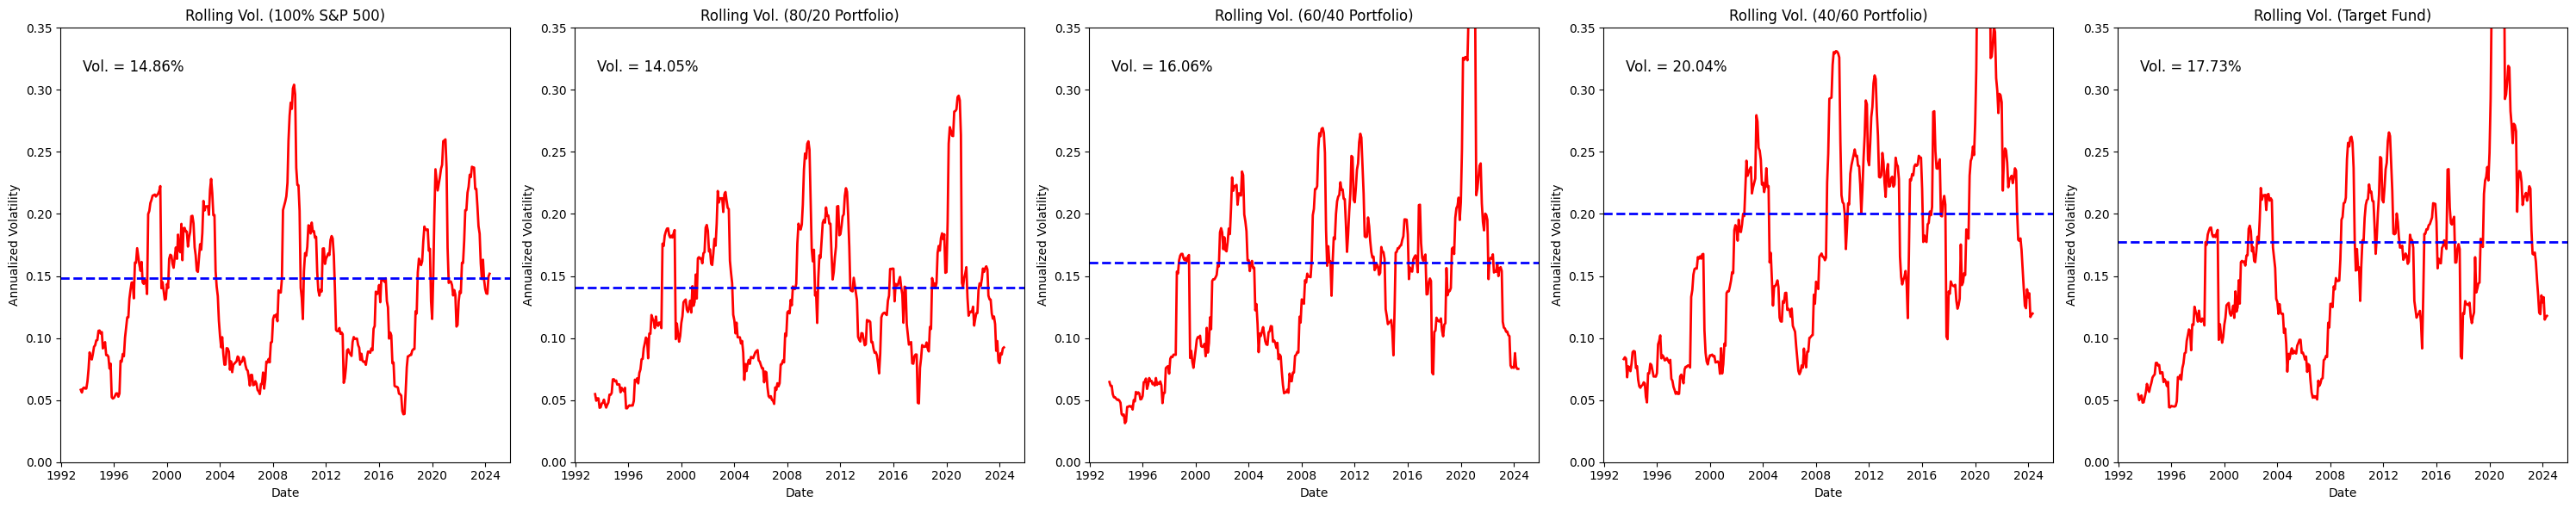

In [32]:
# Create a figure with multiple subplots (one for each portfolio)
fig, ax = plt.subplots(1, 5, figsize=(30, 6)) 
portfolios = {
    'SP500': "100% S&P 500",
    '80/20 Portfolio': "80/20 Portfolio",
    '60/40 Portfolio': "60/40 Portfolio",
    '40/60 Portfolio': "40/60 Portfolio",
    'Target Fund': "Target Fund"
}
for i, (key, title) in enumerate(portfolios.items()):
    # Plot rolling annualized volatility
    ax[i].plot(annualized_rollvol[key], color='red', linewidth=2)
    ax[i].set_title(f"Rolling Vol. ({title})")
    ax[i].set_ylim(0, 0.35)
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Annualized Volatility")

    # Calculate and plot the mean volatility as a horizontal line
    annualized_vol = vol_s(aligned_returns[key]) * np.sqrt(12)
    ax[i].axhline(y=annualized_vol, color='blue', linestyle='--', linewidth=2)
    ax[i].text(0.05, 0.9, f"Vol. = {round(annualized_vol*100, 2)}%", transform=ax[i].transAxes, color='black', fontsize=12)


plt.tight_layout()
plt.show()


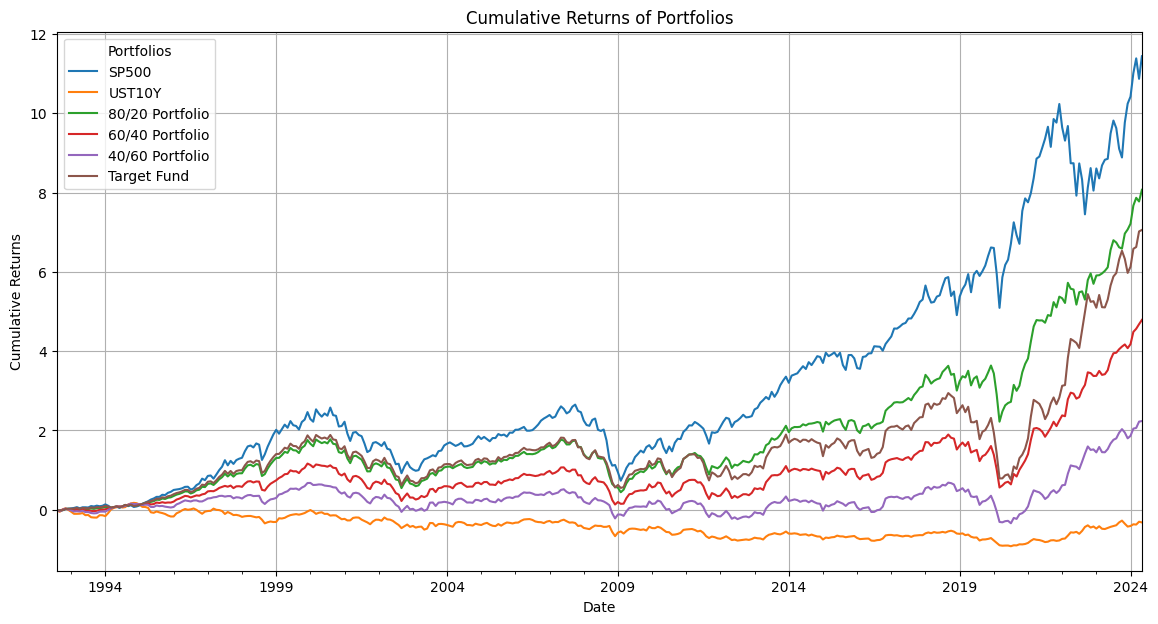

Annualized Returns:
SP500              1.902650
UST10Y             0.733177
80/20 Portfolio    1.668756
60/40 Portfolio    1.434861
40/60 Portfolio    1.200967
Target Fund        1.714233
dtype: float64

Annualized Volatility:
SP500              0.680884
UST10Y             1.405475
80/20 Portfolio    0.643929
60/40 Portfolio    0.735759
40/60 Portfolio    0.918528
Target Fund        0.812704
dtype: float64

Maximum Drawdown:
SP500             -0.525559
UST10Y            -0.932049
80/20 Portfolio   -0.480990
60/40 Portfolio   -0.477082
40/60 Portfolio   -0.608751
Target Fund       -0.554313
dtype: float64

Sharpe Ratio:
SP500              2.794384
UST10Y             0.521658
80/20 Portfolio    2.591520
60/40 Portfolio    1.950177
40/60 Portfolio    1.307491
Target Fund        2.109296
dtype: float64


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume 'aligned_returns' is your DataFrame containing the returns data for each portfolio
# Calculate cumulative returns
cumulative_returns = (1 + aligned_returns).cumprod() - 1

# Calculate annualized average returns
annualized_returns = aligned_returns.mean() * 252  # Assuming 252 trading days

# Calculate annualized volatility
annualized_volatility = aligned_returns.std() * np.sqrt(252)

# Calculate maximum drawdown
rolling_max = (1 + aligned_returns).cumprod().cummax()
daily_drawdown = (1 + aligned_returns).cumprod() / rolling_max - 1
max_drawdown = daily_drawdown.min()

# Calculate Sharpe Ratio (assume risk-free rate = 0)
sharpe_ratio = annualized_returns / annualized_volatility

cumulative_returns.plot(figsize=(14, 7))
plt.title('Cumulative Returns of Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(title="Portfolios")
plt.grid(True)
plt.show()

print("Annualized Returns:")
print(annualized_returns)
print("\nAnnualized Volatility:")
print(annualized_volatility)
print("\nMaximum Drawdown:")
print(max_drawdown)
print("\nSharpe Ratio:")
print(sharpe_ratio)


Overview of Key Metrics:

Standard Deviation: This metric reveals that the SP500 has the lowest volatility, indicating fewer return fluctuations relative to the other portfolios, except for the 80/20 Portfolio. The relatively low standard deviation suggests these portfolios might be less risky compared to those with higher values.

Skewness: The negative skewness observed in most portfolios, except UST10Y, indicates a potential downside risk, where returns might deviate towards lower values more frequently than higher ones. Positive skewness in UST10Y suggests returns are skewed towards higher values, albeit infrequently.
Kurtosis: The Target Fund and the 40/60 Portfolio, which include significant bond allocations, exhibit high kurtosis. This implies a propensity for extreme returns, or "fat tails," which can include both unusually high and low returns. High kurtosis portfolios may experience unexpected volatility that traditional metrics might not fully capture.

Annualized Returns: The SP500 offers the highest returns, potentially appealing for those seeking long-term growth. Its performance suggests a robust capacity for capital appreciation over the assessment period.

Annualized Volatility: The highest volatility found in the UST10Y is indicative of significant risk. This metric is especially relevant in light of recent financial climates marked by fluctuating interest rates.

Maximum Drawdown: UST10Y also shows the most considerable maximum drawdown, a critical concern for investors averse to large potential losses. This suggests periods of substantial value decline from which recovery might be slow.
Sharpe Ratio: The highest Sharpe ratio of the SP500 underscores its superior return per unit of risk, affirming its status as a potentially more efficient investment compared to the other portfolios examined.

Impact of Interest Rate Changes on Bond Volatility:
During the early 2020s, the financial markets experienced significant interest rate changes, notably impacting bond prices and their associated portfolios like UST10Y, 40/60, and to some extent the 60/40 and 80/20 portfolios. Bonds are particularly sensitive to interest rate fluctuations:

Rising Interest Rates: When interest rates rise, existing bonds with fixed interest payments become less attractive compared to newly issued bonds that offer higher yields. This leads to a decrease in the price of existing bonds, thereby increasing their volatility.

Falling Interest Rates: Conversely, when rates fall, existing bonds with higher interest rates become more valuable, increasing their price and reducing volatility, but also leading to sharp increases in bond portfolio values.

The plots provided show heightened periods of volatility corresponding to these rate changes, especially noticeable in portfolios with higher bond allocations. The increased frequency of extreme returns (high kurtosis) during these periods can be attributed to the rapid adjustment of bond prices to new interest rate environments. This reactivity underscores the heightened risk and potential for unexpected returns during periods of economic instability or monetary policy shifts. - do this text in  bullet points in Latex

Recommendations for Investors in Their 30s
For investors in their 30s, it's generally acceptable to adopt a riskier investment strategy due to their longer investment horizon until retirement. This period allows them to recover from potential market downturns, making it feasible to aim for higher returns. In this regard, the SP500 and the 80/20 Portfolio are highly recommended. Both portfolios have demonstrated strong performances with higher returns and manageable volatility, making them excellent choices for those seeking to maximize capital growth. The SP500, in particular, stands out due to its consistent growth and lower volatility compared to other equity-heavy portfolios, making it an optimal choice for investors looking to significantly increase their capital over time.

Recommendations for Investors Approaching Retirement (Aged 60 and Above)
For investors approaching retirement, the primary focus shifts towards capital preservation and minimizing volatility to protect their accrued savings. The financial strategy for these investors should center on maintaining the value of their portfolio with less exposure to high-risk investments. The 40/60 Portfolio and the Target Fund are tailored for such needs, as they offer more conservative risk profiles. These portfolios are designed to provide a stable return while minimizing the risk of significant losses, which is crucial for investors who have less time to recover from market volatilities. The emphasis on safer investment choices helps ensure that their retirement funds are protected against substantial market fluctuations, providing a more secure financial foundation as they move closer to retirement.

In summary, while younger investors can afford to take on more risk to achieve growth, older investors nearing retirement should focus on safeguarding their investments. This tailored approach helps each age group meet their financial goals according to their specific time frames and risk tolerance levels.

Analysis Caveats:

Market Conditions: The analysis may be biased by specific market environments that could change, hence a broader range of conditions should be considered.

Rebalancing Assumptions: It is assumed that the portfolios are rebalanced periodically, which may not always be the case in practice.

Risk Tolerance and Financial Goals: This general analysis does not take into account individual risk preferences and financial objectives, which can vary widely.Inflation and 

Taxes: The returns discussed are nominal and do not consider the effects of inflation or taxes, which can significantly alter real investment outcomes. 

In [19]:
aligned_returns

,SP500,UST10Y,80/20 Portfolio,60/40 Portfolio,40/60 Portfolio,Target Fund
Date,,,,,,
1992-08-01,-0.023998,-0.014881,-0.022174,-0.020351,-0.018528,-0.023086
1992-09-01,0.009106,-0.037764,-0.000268,-0.009642,-0.019016,0.004357
1992-10-01,0.002106,0.067504,0.015186,0.028265,0.041345,0.008818
1992-11-01,0.030262,0.022059,0.028621,0.026981,0.025340,0.029409
1992-12-01,0.010108,-0.035971,0.000892,-0.008324,-0.017540,0.005258
...,...,...,...,...,...,...
2024-01-01,0.015896,0.026125,0.017942,0.019988,0.022033,0.021980
2024-02-01,0.051721,0.071843,0.055745,0.059769,0.063794,0.063715
2024-03-01,0.031019,-0.010818,0.022651,0.014284,0.005916,0.006026
